Grounding DINO box: 6, 99, 493, 381
Point on object (from mask centroid): (154, 249)


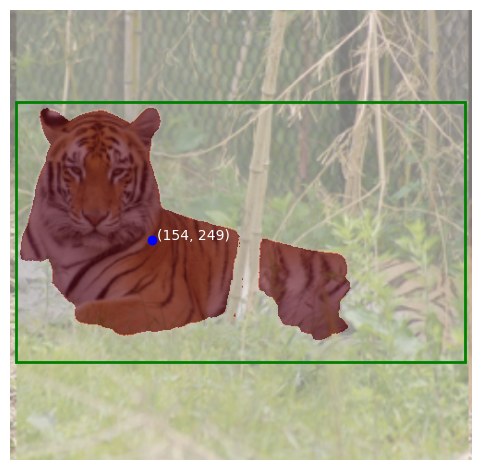

In [26]:
import torch
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoProcessor,
    AutoModelForZeroShotObjectDetection,
    SamModel,
    SamProcessor
)

# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load image ===
img_url = "tiger.png"
image = Image.open(img_url).convert("RGB")
image_np = np.array(image)

# === Step 1: Grounding DINO — predict bounding box from text ===
dino_model_id = "IDEA-Research/grounding-dino-tiny"
dino_processor = AutoProcessor.from_pretrained(dino_model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_model_id).to(device)

text_labels = [["tiger"]]  # You can change this to e.g. ["a tiger"], etc.
inputs = dino_processor(images=image, text=text_labels, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]  # (H, W)
)

# === If any boxes found, continue ===
if len(results[0]["boxes"]) == 0:
    raise ValueError("No object detected for the given text.")

box = results[0]["boxes"][0].tolist()  # Use top box
x0, y0, x1, y1 = map(int, box)
print(f"Grounding DINO box: {x0}, {y0}, {x1}, {y1}")

# === Step 2: Segment Anything (SAM) using box prompt ===
sam_model_id = "facebook/sam-vit-huge"
sam_model = SamModel.from_pretrained(sam_model_id).to(device)
sam_processor = SamProcessor.from_pretrained(sam_model_id)

sam_inputs = sam_processor(image, input_boxes=[[[x0, y0, x1, y1]]], return_tensors="pt").to(device)

with torch.no_grad():
    sam_outputs = sam_model(**sam_inputs)

masks = sam_processor.image_processor.post_process_masks(
    sam_outputs.pred_masks.cpu(),
    sam_inputs["original_sizes"].cpu(),
    sam_inputs["reshaped_input_sizes"].cpu()
)[0]

# === Step 3: Extract a point from the SAM mask (e.g. centroid) ===
mask = masks[0][0].numpy()  # shape [H, W]
ys, xs = np.where(mask)
center_x, center_y = int(xs.mean()), int(ys.mean())
print(f"Point on object (from mask centroid): ({center_x}, {center_y})")

# === Step 4: Visualize box + mask + point ===
fig, ax = plt.subplots(1)
ax.imshow(image_np)
ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor='green', facecolor='none', linewidth=2))
ax.imshow(mask, alpha=0.5, cmap='Reds')
ax.plot(center_x, center_y, 'bo')
ax.text(center_x + 5, center_y, f"({center_x}, {center_y})", color='white')
plt.axis("off")
plt.tight_layout()
plt.show()


In [54]:
import os
import torch
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import (
    AutoProcessor,
    AutoModelForZeroShotObjectDetection,
    SamModel,
    SamProcessor
)
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "sampled"
output_dir = "center_points"
os.makedirs(output_dir, exist_ok=True)

# Load or initialize results
json_path = os.path.join(output_dir, "results.json")
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        results = json.load(f)
else:
    results = {}

# Load models
dino_model_id = "IDEA-Research/grounding-dino-tiny"
sam_model_id = "facebook/sam-vit-huge"

dino_processor = AutoProcessor.from_pretrained(dino_model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_model_id).to(device)

sam_processor = SamProcessor.from_pretrained(sam_model_id)
sam_model = SamModel.from_pretrained(sam_model_id).to(device)

# Process each image
for index_dir in tqdm(sorted(os.listdir(root_dir))):
    if int(index_dir) < 800:
        continue

    overlay_path = os.path.join(output_dir, f"{index_dir}_overlay.png")
    if os.path.exists(overlay_path):
        continue  # Skip if overlay image already exists

    index_path = os.path.join(root_dir, index_dir)
    if not os.path.isdir(index_path):
        continue

    photo_file = next((f for f in os.listdir(index_path) if "photo" in f), None)
    if not photo_file:
        print(f"[WARN] No photo in {index_dir}")
        continue

    grounding_text = photo_file.split("_")[0]
    photo_path = os.path.join(index_path, photo_file)

    try:
        image = Image.open(photo_path).convert("RGB")
        image_np = np.array(image)

        dino_inputs = dino_processor(images=image, text=[[grounding_text]], return_tensors="pt").to(device)
        with torch.no_grad():
            dino_outputs = dino_model(**dino_inputs)
        dino_results = dino_processor.post_process_grounded_object_detection(
            dino_outputs,
            dino_inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )

        if len(dino_results[0]["boxes"]) == 0:
            print(f"[INFO] No box found for {photo_path}")
            continue

        x0, y0, x1, y1 = map(int, dino_results[0]["boxes"][0].tolist())

        sam_inputs = sam_processor(image, input_boxes=[[[x0, y0, x1, y1]]], return_tensors="pt").to(device)
        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)
        sam_masks = sam_processor.image_processor.post_process_masks(
            sam_outputs.pred_masks.cpu(),
            sam_inputs["original_sizes"].cpu(),
            sam_inputs["reshaped_input_sizes"].cpu()
        )[0]

        mask = sam_masks[0][0].numpy()
        ys, xs = np.where(mask)
        if len(xs) == 0 or len(ys) == 0:
            print(f"[WARN] Empty mask for {photo_path}")
            continue

        center_x, center_y = int(xs.mean()), int(ys.mean())

        results[index_dir] = {
            "class": grounding_text,
            "bbox": [x0, y0, x1, y1],
            "center": [center_x, center_y]
        }

        fig, ax = plt.subplots()
        ax.imshow(image_np)
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor='green', facecolor='none', linewidth=2))
        ax.imshow(mask, alpha=0.4, cmap="Reds")
        ax.plot(center_x, center_y, 'bo')
        ax.text(center_x + 5, center_y, f"({center_x},{center_y})", color="blue")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(overlay_path)
        plt.close()

    except Exception as e:
        print(f"[ERROR] Failed {index_dir}: {e}")

with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Done! Results saved to {json_path} and overlay images in {output_dir}")


  3%|█▍                                       | 43/1250 [00:02<00:59, 20.14it/s]

[INFO] No box found for sampled/1035/pineapple_n07753275_137_photo.jpg


  5%|██                                       | 61/1250 [00:03<01:15, 15.69it/s]

[INFO] No box found for sampled/1051/volcano_n09472597_32918_photo.jpg


 11%|████▍                                   | 139/1250 [00:05<00:36, 30.20it/s]

[INFO] No box found for sampled/1121/geyser_n09288635_13306_photo.jpg


 11%|████▌                                   | 143/1250 [00:06<00:56, 19.63it/s]

[INFO] No box found for sampled/1125/geyser_n09288635_10954_photo.jpg


 12%|████▋                                   | 145/1250 [00:08<01:21, 13.56it/s]

[INFO] No box found for sampled/1127/geyser_n09288635_13114_photo.jpg


 13%|█████▏                                  | 162/1250 [00:09<01:24, 12.89it/s]

[INFO] No box found for sampled/1142/hot-air_balloon_n03541923_1646_photo.jpg


 19%|███████▌                                | 238/1250 [00:11<00:40, 25.22it/s]

[INFO] No box found for sampled/1210/snake_n01726692_9144_photo.jpg


 20%|████████▏                               | 254/1250 [00:12<00:47, 20.77it/s]

[INFO] No box found for sampled/1225/knife_n02976123_5626_photo.jpg


 83%|███████████████████████████████▍      | 1036/1250 [00:14<00:01, 169.10it/s]

[INFO] No box found for sampled/805/eyeglasses_n04356056_3374_photo.jpg


 88%|██████████████████████████████████▏    | 1097/1250 [04:47<15:33,  6.10s/it]

[INFO] No box found for sampled/860/bat_n02139199_7402_photo.jpg
[INFO] No box found for sampled/861/bat_n02139199_5680_photo.jpg
[INFO] No box found for sampled/862/bat_n02139199_11363_photo.jpg
[INFO] No box found for sampled/863/bat_n02139199_10978_photo.jpg
[INFO] No box found for sampled/864/bat_n02139199_9033_photo.jpg
[INFO] No box found for sampled/865/bat_n02149420_28_photo.jpg
[INFO] No box found for sampled/866/bat_n02139199_13810_photo.jpg
[INFO] No box found for sampled/867/bat_n02147947_5693_photo.jpg


 89%|██████████████████████████████████▌    | 1108/1250 [05:21<08:29,  3.59s/it]

[INFO] No box found for sampled/870/fan_n03271574_304_photo.jpg


 89%|██████████████████████████████████▋    | 1111/1250 [05:44<11:21,  4.90s/it]

[INFO] No box found for sampled/873/fan_n03271574_27897_photo.jpg


 89%|██████████████████████████████████▊    | 1116/1250 [06:28<15:02,  6.74s/it]

[INFO] No box found for sampled/878/fan_n03271574_3853_photo.jpg


 92%|███████████████████████████████████▊   | 1147/1250 [11:00<12:09,  7.08s/it]

[INFO] No box found for sampled/905/rocket_n03773504_21920_photo.jpg


 92%|███████████████████████████████████▉   | 1150/1250 [11:24<11:40,  7.01s/it]

[INFO] No box found for sampled/908/rocket_n04415663_11293_photo.jpg


 92%|███████████████████████████████████▉   | 1152/1250 [11:25<07:20,  4.49s/it]

[INFO] No box found for sampled/909/rocket_n03773504_6145_photo.jpg


 95%|█████████████████████████████████████  | 1189/1250 [17:25<07:44,  7.62s/it]

[INFO] No box found for sampled/943/axe_n02764044_10196_photo.jpg


 96%|█████████████████████████████████████▎ | 1195/1250 [18:19<06:54,  7.53s/it]

[INFO] No box found for sampled/949/axe_n02764044_21704_photo.jpg


 96%|█████████████████████████████████████▌ | 1203/1250 [19:24<05:43,  7.31s/it]

[INFO] No box found for sampled/956/castle_n02980441_33984_photo.jpg


100%|███████████████████████████████████████| 1250/1250 [27:10<00:00,  1.30s/it]


✅ Done! Results saved to center_points/results.json and overlay images in center_points


In [57]:
import os
import torch
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import (
    AutoProcessor,
    AutoModelForZeroShotObjectDetection,
    SamModel,
    SamProcessor
)
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "sampled"
output_dir = "SAM_exports"
os.makedirs(output_dir, exist_ok=True)
mask_dir = os.path.join(output_dir, "masks")
os.makedirs(mask_dir, exist_ok=True)

# Load or initialize results
json_path = os.path.join(output_dir, "results.json")
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        results = json.load(f)
else:
    results = {}

# Load models
dino_model_id = "IDEA-Research/grounding-dino-tiny"
sam_model_id = "facebook/sam-vit-huge"

dino_processor = AutoProcessor.from_pretrained(dino_model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_model_id).to(device)

sam_processor = SamProcessor.from_pretrained(sam_model_id)
sam_model = SamModel.from_pretrained(sam_model_id).to(device)

# Process each image
for index_dir in tqdm(sorted(os.listdir(root_dir))):
    # if int(index_dir) < 800:
    #     continue

    overlay_path = os.path.join(output_dir, f"{index_dir}_overlay.png")
    mask_path = os.path.join(mask_dir, f"{index_dir}_mask.png")
    if os.path.exists(overlay_path) and os.path.exists(mask_path):
        continue  # Skip if outputs already exist

    index_path = os.path.join(root_dir, index_dir)
    if not os.path.isdir(index_path):
        continue

    # Get photo filename
    photo_file = next((f for f in os.listdir(index_path) if "photo" in f), None)
    if not photo_file:
        print(f"[WARN] No photo in {index_dir}")
        continue

    grounding_text = photo_file.split("_")[0]
    photo_path = os.path.join(index_path, photo_file)

    try:
        image = Image.open(photo_path).convert("RGB")
        image_np = np.array(image)

        dino_inputs = dino_processor(images=image, text=[[grounding_text]], return_tensors="pt").to(device)
        with torch.no_grad():
            dino_outputs = dino_model(**dino_inputs)
        dino_results = dino_processor.post_process_grounded_object_detection(
            dino_outputs,
            dino_inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )

        if len(dino_results[0]["boxes"]) == 0:
            print(f"[INFO] No box found for {photo_path}")
            continue

        x0, y0, x1, y1 = map(int, dino_results[0]["boxes"][0].tolist())

        sam_inputs = sam_processor(image, input_boxes=[[[x0, y0, x1, y1]]], return_tensors="pt").to(device)
        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)
        sam_masks = sam_processor.image_processor.post_process_masks(
            sam_outputs.pred_masks.cpu(),
            sam_inputs["original_sizes"].cpu(),
            sam_inputs["reshaped_input_sizes"].cpu()
        )[0]

        mask = sam_masks[0][0].numpy()
        ys, xs = np.where(mask)
        if len(xs) == 0 or len(ys) == 0:
            print(f"[WARN] Empty mask for {photo_path}")
            continue

        center_x, center_y = int(xs.mean()), int(ys.mean())

        mask_img = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")
        mask_img.save(mask_path)

        # --- Save JSON entry ---
        results[index_dir] = {
            "class": grounding_text,
            "bbox": [x0, y0, x1, y1],
            "center": [center_x, center_y],
            "mask_path": os.path.relpath(mask_path, start=output_dir)  # Save relative path
        }

        # --- Save overlay image for visualization ---
        fig, ax = plt.subplots()
        ax.imshow(image_np)
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor='green', facecolor='none', linewidth=2))
        ax.imshow(mask, alpha=0.4, cmap="Reds")
        ax.plot(center_x, center_y, 'bo')
        ax.text(center_x + 5, center_y, f"({center_x},{center_y})", color="blue")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(overlay_path)
        plt.close()

    except Exception as e:
        print(f"[ERROR] Failed {index_dir}: {e}")

with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Done! Results saved to {json_path}, masks in {mask_dir}, overlays in {output_dir}")


  3%|█▍                                       | 43/1250 [01:13<19:44,  1.02it/s]

[INFO] No box found for sampled/1035/pineapple_n07753275_137_photo.jpg


  5%|██                                       | 61/1250 [01:35<21:17,  1.07s/it]

[INFO] No box found for sampled/1051/volcano_n09472597_32918_photo.jpg


 11%|████▍                                   | 139/1250 [02:57<19:45,  1.07s/it]

[INFO] No box found for sampled/1121/geyser_n09288635_13306_photo.jpg


 11%|████▌                                   | 143/1250 [02:59<17:16,  1.07it/s]

[INFO] No box found for sampled/1125/geyser_n09288635_10954_photo.jpg


 12%|████▋                                   | 145/1250 [03:01<16:54,  1.09it/s]

[INFO] No box found for sampled/1127/geyser_n09288635_13114_photo.jpg


 13%|█████                                   | 159/1250 [03:12<13:47,  1.32it/s]

[INFO] No box found for sampled/114/piano_n03452741_5409_photo.jpg


 13%|█████▏                                  | 162/1250 [03:14<12:58,  1.40it/s]

[INFO] No box found for sampled/1142/hot-air_balloon_n03541923_1646_photo.jpg


 19%|███████▌                                | 238/1250 [04:37<19:56,  1.18s/it]

[INFO] No box found for sampled/1210/snake_n01726692_9144_photo.jpg


 20%|████████▏                               | 254/1250 [04:49<14:51,  1.12it/s]

[INFO] No box found for sampled/1225/knife_n02976123_5626_photo.jpg


 28%|██████████▌                           | 348/1250 [16:21<1:50:14,  7.33s/it]

[INFO] No box found for sampled/186/snail_n01944390_7195_photo.jpg


 30%|███████████▏                          | 369/1250 [19:45<1:51:13,  7.58s/it]

[INFO] No box found for sampled/204/ape_n02480495_190_photo.jpg


 33%|████████████▍                         | 411/1250 [26:43<1:43:26,  7.40s/it]

[INFO] No box found for sampled/242/racket_n04039381_2051_photo.jpg


 33%|████████████▌                         | 412/1250 [26:45<1:18:27,  5.62s/it]

[INFO] No box found for sampled/243/racket_n04039381_7038_photo.jpg


 33%|████████████▌                         | 413/1250 [26:46<1:00:55,  4.37s/it]

[INFO] No box found for sampled/244/racket_n04039381_10664_photo.jpg


 33%|████████████▌                         | 415/1250 [26:58<1:04:46,  4.65s/it]

[INFO] No box found for sampled/246/racket_n04039381_838_photo.jpg


 33%|████████████▋                         | 418/1250 [27:19<1:17:58,  5.62s/it]

[INFO] No box found for sampled/249/racket_n02772700_7021_photo.jpg


 34%|████████████▊                         | 422/1250 [27:51<1:29:31,  6.49s/it]

[INFO] No box found for sampled/252/turtle_n01669191_8875_photo.jpg


 35%|█████████████▏                        | 434/1250 [29:43<1:39:30,  7.32s/it]

[INFO] No box found for sampled/263/hourglass_n03544143_9427_photo.jpg


 35%|█████████████▍                        | 442/1250 [30:53<1:36:52,  7.19s/it]

[INFO] No box found for sampled/270/saw_n04140064_35526_photo.jpg


 35%|█████████████▍                        | 443/1250 [30:55<1:13:34,  5.47s/it]

[INFO] No box found for sampled/271/saw_n04140064_4388_photo.jpg


 36%|█████████████▌                        | 447/1250 [31:26<1:24:33,  6.32s/it]

[INFO] No box found for sampled/275/saw_n04140064_7911_photo.jpg


 36%|█████████████▌                        | 448/1250 [31:27<1:04:57,  4.86s/it]

[INFO] No box found for sampled/276/saw_n04140064_8236_photo.jpg


 36%|█████████████▋                        | 450/1250 [31:39<1:05:35,  4.92s/it]

[INFO] No box found for sampled/278/saw_n04140064_2810_photo.jpg


 36%|██████████████▍                         | 451/1250 [31:40<51:38,  3.88s/it]

[INFO] No box found for sampled/279/saw_n04140064_6901_photo.jpg


 38%|██████████████▎                       | 472/1250 [35:03<1:37:12,  7.50s/it]

[INFO] No box found for sampled/298/rifle_n04090263_18979_photo.jpg


 38%|██████████████▍                       | 475/1250 [35:25<1:25:57,  6.66s/it]

[INFO] No box found for sampled/30/ant_n02219486_28127_photo.jpg


 42%|████████████████                      | 528/1250 [49:42<1:31:50,  7.63s/it]

[INFO] No box found for sampled/348/dolphin_n02068974_2138_photo.jpg


 42%|████████████████                      | 530/1250 [49:54<1:16:38,  6.39s/it]

[INFO] No box found for sampled/35/ant_n02219486_27411_photo.jpg


 50%|█████████████████▊                  | 619/1250 [1:04:55<1:18:15,  7.44s/it]

[INFO] No box found for sampled/43/tree_n12726670_6261_photo.jpg


 54%|███████████████████▍                | 673/1250 [1:13:46<1:10:45,  7.36s/it]

[INFO] No box found for sampled/479/shoe_n04120489_1442_photo.jpg


 65%|████████████████████████▊             | 816/1250 [1:37:02<53:08,  7.35s/it]

[INFO] No box found for sampled/607/wheelchair_n04576002_6100_photo.jpg


 66%|████████████████████████▉             | 820/1250 [1:37:34<48:24,  6.75s/it]

[INFO] No box found for sampled/610/seal_n02077923_480_photo.jpg


 67%|█████████████████████████▎            | 833/1250 [1:39:33<50:15,  7.23s/it]

[INFO] No box found for sampled/622/jellyfish_n01910747_17233_photo.jpg


 68%|█████████████████████████▉            | 853/1250 [1:42:42<48:04,  7.27s/it]

[INFO] No box found for sampled/640/mouse_n02330245_4390_photo.jpg


 68%|█████████████████████████▉            | 854/1250 [1:42:43<36:29,  5.53s/it]

[INFO] No box found for sampled/641/mouse_n02330245_5245_photo.jpg


 68%|█████████████████████████▉            | 855/1250 [1:42:44<28:19,  4.30s/it]

[INFO] No box found for sampled/642/mouse_n02330245_4571_photo.jpg


 68%|██████████████████████████            | 856/1250 [1:42:46<22:36,  3.44s/it]

[INFO] No box found for sampled/643/mouse_n02330245_3252_photo.jpg


 69%|██████████████████████████            | 857/1250 [1:42:47<18:37,  2.84s/it]

[INFO] No box found for sampled/644/mouse_n02330245_2930_photo.jpg


 69%|██████████████████████████            | 858/1250 [1:42:49<15:49,  2.42s/it]

[INFO] No box found for sampled/645/mouse_n02330245_11922_photo.jpg


 69%|██████████████████████████            | 859/1250 [1:42:50<13:53,  2.13s/it]

[INFO] No box found for sampled/646/mouse_n02330245_561_photo.jpg


 69%|██████████████████████████▏           | 861/1250 [1:43:01<22:54,  3.53s/it]

[INFO] No box found for sampled/648/mouse_n02330245_9608_photo.jpg


 69%|██████████████████████████▏           | 862/1250 [1:43:03<18:46,  2.90s/it]

[INFO] No box found for sampled/649/mouse_n02330245_6577_photo.jpg


 72%|███████████████████████████▏          | 896/1250 [1:48:28<43:01,  7.29s/it]

[INFO] No box found for sampled/68/sword_n04373894_35066_photo.jpg


 75%|████████████████████████████▋         | 943/1250 [1:55:55<36:59,  7.23s/it]

[INFO] No box found for sampled/721/armor_n03000247_20859_photo.jpg


 79%|██████████████████████████████        | 987/1250 [2:02:56<31:59,  7.30s/it]

[INFO] No box found for sampled/761/umbrella_n04507155_200_photo.jpg


 81%|██████████████████████████████       | 1015/1250 [2:07:21<28:23,  7.25s/it]

[INFO] No box found for sampled/787/chicken_n01791625_8055_photo.jpg


 82%|██████████████████████████████▏      | 1019/1250 [2:07:52<25:35,  6.65s/it]

[INFO] No box found for sampled/790/bell_n03028596_4159_photo.jpg


 82%|██████████████████████████████▏      | 1021/1250 [2:08:03<21:51,  5.73s/it]

[INFO] No box found for sampled/792/bell_n03028596_5115_photo.jpg


 83%|██████████████████████████████▋      | 1036/1250 [2:09:32<10:10,  2.85s/it]

[INFO] No box found for sampled/805/eyeglasses_n04356056_3374_photo.jpg


 88%|████████████████████████████████▍    | 1097/1250 [2:10:31<02:31,  1.01it/s]

[INFO] No box found for sampled/860/bat_n02139199_7402_photo.jpg


 88%|████████████████████████████████▌    | 1098/1250 [2:10:33<02:34,  1.01s/it]

[INFO] No box found for sampled/861/bat_n02139199_5680_photo.jpg


 88%|████████████████████████████████▌    | 1099/1250 [2:10:34<02:37,  1.05s/it]

[INFO] No box found for sampled/862/bat_n02139199_11363_photo.jpg


 88%|████████████████████████████████▌    | 1100/1250 [2:10:36<02:42,  1.08s/it]

[INFO] No box found for sampled/863/bat_n02139199_10978_photo.jpg


 88%|████████████████████████████████▌    | 1101/1250 [2:10:37<02:47,  1.12s/it]

[INFO] No box found for sampled/864/bat_n02139199_9033_photo.jpg


 88%|████████████████████████████████▌    | 1102/1250 [2:10:39<02:53,  1.17s/it]

[INFO] No box found for sampled/865/bat_n02149420_28_photo.jpg


 88%|████████████████████████████████▋    | 1103/1250 [2:10:40<02:58,  1.21s/it]

[INFO] No box found for sampled/866/bat_n02139199_13810_photo.jpg


 88%|████████████████████████████████▋    | 1104/1250 [2:10:41<03:02,  1.25s/it]

[INFO] No box found for sampled/867/bat_n02147947_5693_photo.jpg


 89%|████████████████████████████████▊    | 1108/1250 [2:10:53<04:48,  2.03s/it]

[INFO] No box found for sampled/870/fan_n03271574_304_photo.jpg


 89%|████████████████████████████████▉    | 1111/1250 [2:10:54<03:08,  1.35s/it]

[INFO] No box found for sampled/873/fan_n03271574_27897_photo.jpg


 89%|█████████████████████████████████    | 1116/1250 [2:10:55<01:48,  1.24it/s]

[INFO] No box found for sampled/878/fan_n03271574_3853_photo.jpg


 89%|█████████████████████████████████    | 1118/1250 [2:10:57<01:43,  1.27it/s]

[INFO] No box found for sampled/88/strawberry_n07745940_2690_photo.jpg


 91%|█████████████████████████████████▊   | 1141/1250 [2:11:18<01:37,  1.11it/s]

[INFO] No box found for sampled/90/raccoon_n02508021_72_photo.jpg


 92%|█████████████████████████████████▉   | 1147/1250 [2:11:19<01:09,  1.48it/s]

[INFO] No box found for sampled/905/rocket_n03773504_21920_photo.jpg


 92%|██████████████████████████████████   | 1150/1250 [2:11:20<01:03,  1.56it/s]

[INFO] No box found for sampled/908/rocket_n04415663_11293_photo.jpg


 92%|██████████████████████████████████   | 1151/1250 [2:11:22<01:09,  1.42it/s]

[INFO] No box found for sampled/909/rocket_n03773504_6145_photo.jpg


 92%|██████████████████████████████████   | 1152/1250 [2:11:23<01:17,  1.27it/s]

[INFO] No box found for sampled/91/raccoon_n02508021_10406_photo.jpg


 93%|██████████████████████████████████▍  | 1163/1250 [2:11:25<00:32,  2.66it/s]

[INFO] No box found for sampled/92/raccoon_n02508021_975_photo.jpg


 95%|███████████████████████████████████▏ | 1189/1250 [2:11:46<00:40,  1.51it/s]

[INFO] No box found for sampled/943/axe_n02764044_10196_photo.jpg


 96%|███████████████████████████████████▎ | 1195/1250 [2:11:47<00:30,  1.83it/s]

[INFO] No box found for sampled/949/axe_n02764044_21704_photo.jpg


 96%|███████████████████████████████████▍ | 1196/1250 [2:11:49<00:32,  1.67it/s]

[INFO] No box found for sampled/95/raccoon_n02508021_12996_photo.jpg


 96%|███████████████████████████████████▌ | 1203/1250 [2:11:50<00:21,  2.23it/s]

[INFO] No box found for sampled/956/castle_n02980441_33984_photo.jpg


 97%|███████████████████████████████████▋ | 1207/1250 [2:11:51<00:18,  2.34it/s]

[INFO] No box found for sampled/96/raccoon_n02508021_11569_photo.jpg


 97%|████████████████████████████████████ | 1218/1250 [2:11:53<00:09,  3.52it/s]

[INFO] No box found for sampled/97/raccoon_n02508021_893_photo.jpg


100%|█████████████████████████████████████| 1250/1250 [2:12:04<00:00,  6.34s/it]

[INFO] No box found for sampled/99/raccoon_n02508021_11436_photo.jpg

✅ Done! Results saved to SAM_exports/results.json, masks in SAM_exports/masks, overlays in SAM_exports


In [58]:
from pathlib import Path

root = Path("SAM_exports")  #

success_files = [
    f.name for f in root.iterdir()
    if f.name.endswith('.png')
]

success = [int(f.split("_")[0]) for f in success_files]

print("Successes:",len(success))
print("Failures:", 1250 - len(success))

print("Proportion Successful=", len(success)/1250)

all_samples = list(range(0,1250))

diff = list(set(all_samples)-set(success))

print(diff)

Successes: 1176
Failures: 74
Proportion Successful= 0.9408
[640, 641, 642, 643, 644, 645, 646, 263, 648, 649, 905, 1035, 908, 909, 270, 271, 1121, 275, 276, 787, 278, 279, 790, 792, 1051, 1125, 30, 35, 805, 1127, 298, 43, 943, 949, 186, 1210, 956, 68, 1225, 204, 721, 88, 90, 91, 92, 348, 860, 95, 96, 97, 479, 99, 607, 610, 861, 862, 863, 864, 865, 866, 867, 870, 622, 873, 878, 114, 242, 243, 244, 246, 761, 1142, 249, 252]
